# CROP-seq KO15 - Mixscape analysis of all cells simultaneously
- input: filtered seurat object
- output: real perturbed cells, LDA UMAP plot,...

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(dplyr)
library(reshape2)
library(stringr)
library(ggrepel)


# Setup custom theme for plotting.
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# configs
data_path <- file.path('results','KO15')

fine_mode <- FALSE
# fine_mode <- TRUE

if (fine_mode){
    mixscape_dir = "mixscape_finemode"
} else{
    mixscape_dir = "mixscape"
}

results_path <- file.path(data_path, mixscape_dir, 'all')

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE, recursive = TRUE)

# load filtered Seurat object

In [5]:
# loading Seurat object
KO15 <-readRDS(file = file.path(data_path,paste0("KO15_filtered_Seurat.rds")))
KO15

An object of class Seurat 
31135 features across 9153 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

## prepare metadata

In [6]:
KO15[['condition']] <- str_split_fixed(KO15$hto_demux, "_", 2)[,2]
unique(KO15$condition)

[1] "LO28_2h"   "untreated" "LO28_6h"

# prepare seurat object for mixscape analysis
ie create new columns, named accoring to example data of vignette

In [15]:
# column gene
KO15[["gene"]] <- substring(KO15$KO_call,2)
KO15$gene[KO15$gene=="Non-targeting"] <- 'NT'

In [16]:
# column NT
KO15[["NT"]] <- substring(str_replace(KO15$guide_call, '_', 'g'),2)
KO15$NT[grep("^Non-targeting",KO15$NT)] <- 'NT'

In [17]:
# column crispr for distinguishing perturbed & non-perturbed cells
KO15[["crispr"]] <- KO15$gene
KO15$crispr[KO15$crispr!="NT"] <- "Perturbed"

In [19]:
KO15[[c("gene","NT","crispr")]][1:10,]

,gene,NT,crispr
,<chr>,<chr>,<chr>
1_AAACCTGAGAAGAAGC-1,Stat1,Stat1g3,Perturbed
1_AAACCTGAGACTGTAA-1,Irf8,Irf8g4,Perturbed
1_AAACCTGAGGTGTTAA-1,Kdm1b,Kdm1bg3,Perturbed
1_AAACCTGCAGGCAGTA-1,NT,NT,NT
1_AAACCTGCAGTCGTGC-1,Hdac6,Hdac6g2,Perturbed
1_AAACCTGCATTCTCAT-1,Irf9,Irf9g4,Perturbed
1_AAACCTGTCACTCCTG-1,Stat1,Stat1g3,Perturbed
1_AAACGGGAGAGGGCTT-1,NT,NT,NT
1_AAACGGGAGCCAGAAC-1,Tyk2,Tyk2g4,Perturbed


# Mixscape

In [20]:
# Normalize protein.
KO15 <- NormalizeData(
  object = KO15, 
  assay = "AB", 
  normalization.method = "CLR", 
  margin = 2)

Normalizing across cells



In [21]:
# Prepare RNA assay for dimensionality reduction: 
# Normalize data, find variable features and scale data.
DefaultAssay(object = KO15) <- 'RNA'
KO15 <- NormalizeData(object = KO15) %>% FindVariableFeatures() %>% ScaleData()

# Run Principle Component Analysis (PCA) to reduce the dimensionality of the data.
KO15 <- RunPCA(object = KO15)

# Run Uniform Manifold Approximation and Projection (UMAP) to visualize clustering in 2-D.
KO15 <- RunUMAP(object = KO15, dims = 1:40)

Centering and scaling data matrix

PC_ 1 
Positive:  Ifit1, Rsad2, Cmpk2, Slfn2, Oasl1, Isg15, Ccl3, Ifit3, Ifit2, Ifih1 
	   Acod1, Marcksl1, Tor3a, Ccl5, Apol9a, Ccl9, Mx1, A530040E14Rik, Isg20, Ptgs2 
	   Ccl4, Sqstm1, Mir155hg, Mt1, Usp18, Mt2, Ifi207, Ifi202b, Traf1, Lilr4b 
Negative:  Tubb5, Pclaf, Hmgb2, H2afz, Birc5, Stmn1, Tk1, Mki67, Top2a, Cks1b 
	   Tuba1b, Ccna2, Hmgb1, Aurkb, H2afx, Dut, Lmnb1, Tipin, Cdk1, Tmpo 
	   Incenp, Ube2c, Cenpa, Ccnb2, Asf1b, Tpx2, Cdca8, Cdca3, Scd2, Gmnn 
PC_ 2 
Positive:  Fth1, Lgals3, Ier3, Hilpda, Ftl1, Clec4e, Lyz2, Osm, Trem2, Fosl2 
	   Nr4a1, Cxcl2, Slc2a1, S100a6, Tnfsf9, Plek, Lilr4b, Bhlhe40, Cst3, P4hb 
	   Vim, Cd14, Ccl2, Neat1, Fxyd2, Ctsb, Spp1, Cebpb, Zfp36, Lgals1 
Negative:  Arl6ip1, Isg20, Top2a, Mki67, Oasl2, Usp18, Tubb4b, Phf11d, Hmgb2, Irgm1 
	   Ube2s, Ube2c, Daxx, Igtp, Rnf213, Xaf1, Mx1, Tap1, Ubb, Ifi44 
	   H2-T22, Ifit3, Trim30a, Smc2, Pml, Ifi47, H2-Q4, Parp14, Herc6, Cenpf 
PC_ 3 
Positive:  Cxcl10, Ccl4, Tnf, At

In [22]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [23]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [24]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [25]:
# determine cell cycle scores
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO15 <- CellCycleScoring(KO15, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [26]:
DefaultAssay(object = KO15) <- 'RNA'

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



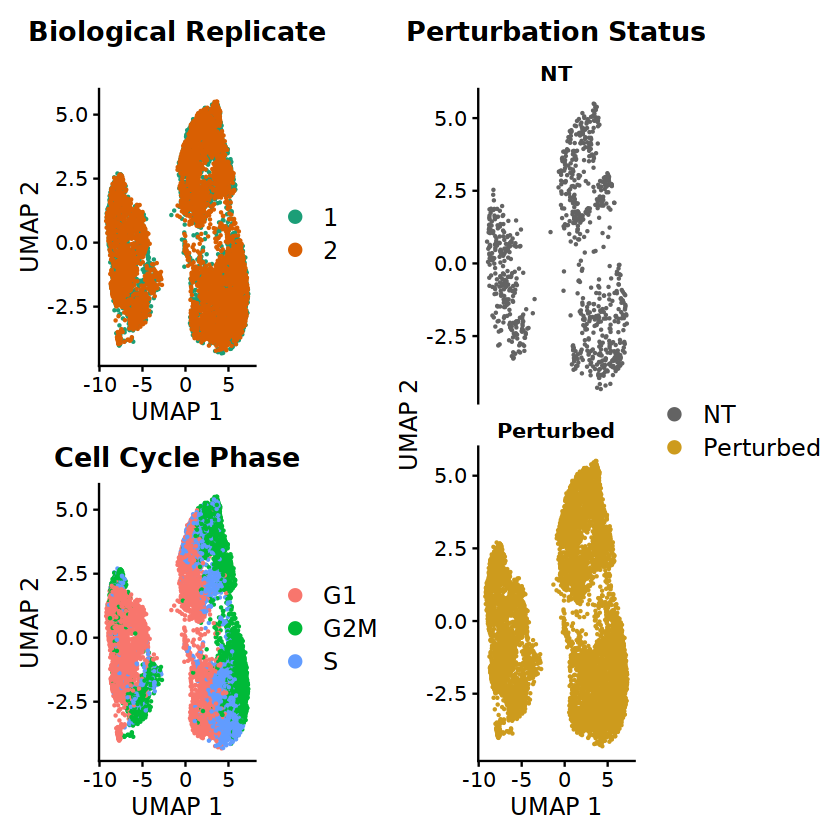

In [27]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
p1 <- DimPlot(
  object = KO15, 
  group.by = 'batch', 
  label = F, 
  pt.size = 0.2, 
  reduction = "umap", cols = "Dark2", repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  xlab("UMAP 1") +
  ylab("UMAP 2") +
  custom_theme

p2 <- DimPlot(
  object = KO15, 
  group.by = 'Phase', 
  label = F, pt.size = 0.2, 
  reduction = "umap", repel = T) + 
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

p3 <- DimPlot(
  object = KO15, 
  group.by = 'crispr', 
  pt.size = 0.2, 
  reduction = "umap", 
  split.by = "crispr", 
  ncol = 1, 
  cols = c("grey39","goldenrod3")) + 
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
((p1 / p2 + plot_layout(guides = 'auto')) | p3 )
# ((p1 / p1 + plot_layout(guides = 'auto')) | p3 )

ggsave(
  paste0("KO15_","_UMAP_prePerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [28]:
# Calculate perturbation signature (PRTB).
KO15 <- CalcPerturbSig(
  object = KO15, 
  assay = "RNA", 
  slot = "data", 
  gd.class ="gene", 
  nt.cell.class = "NT", 
  reduction = "pca", 
  ndims = 40, 
  num.neighbors = 30, 
  split.by = "condition", # experiment
  new.assay.name = "PRTB")

Processing LO28_2h

Processing untreated

Processing LO28_6h



In [29]:
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = KO15) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = KO15) <- VariableFeatures(object = KO15[["RNA"]])
KO15 <- ScaleData(object = KO15, do.scale = F, do.center = T)

# Run PCA to reduce the dimensionality of the data.
KO15 <- RunPCA(object = KO15, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
KO15 <- RunUMAP(
  object = KO15, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Centering data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Irf7, Isg15, Ifi27l2a, Usp18, Bst2, Rsad2, Cxcl2, Isg20, Cxcl10, Ly6e 
	   Phf11d, Il1a, Ifi44, Il1b, Oasl1, Slfn4, Ifit2, Ifit1, Tnf, Rtp4 
	   Ifitm3, Ccl4, Cmpk2, Xaf1, Ifi202b, Rnf213, Ifi207, Ifih1, Ifit3, Oasl2 
Negative:  Ifi27, mt-Cytb, H2-Aa, H2-Eb1, Mt1, Hist1h1e, Vim, Lyz2, H2afz, Hist1h1b 
	   Fen1, Fth1, Pgp, Scd2, Lars2, Ero1l, Pclaf, Ahnak, Asf1b, Herpud1 
	   Rpa2, Nrm, Cks1b, H2-DMa, Lgals1, Gmnn, Cyth4, Slc16a3, Stmn1, Efhd2 
prtbpca_ 2 
Positive:  Irf7, Ifi27l2a, Bst2, Isg15, Usp18, Ly6e, Ifi44, Isg20, Ifitm3, Phf11d 
	   Lgals9, Rnf213, Xaf1, Npc2, Rtp4, Oasl2, Lgals3bp, Ifi202b, Ddx58, Slfn4 
	   Oas1a, Grn, Irgm1, H2-K1, Apol9a, Ifit1, Ifi35, Eif2ak2, H2-T22, S

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



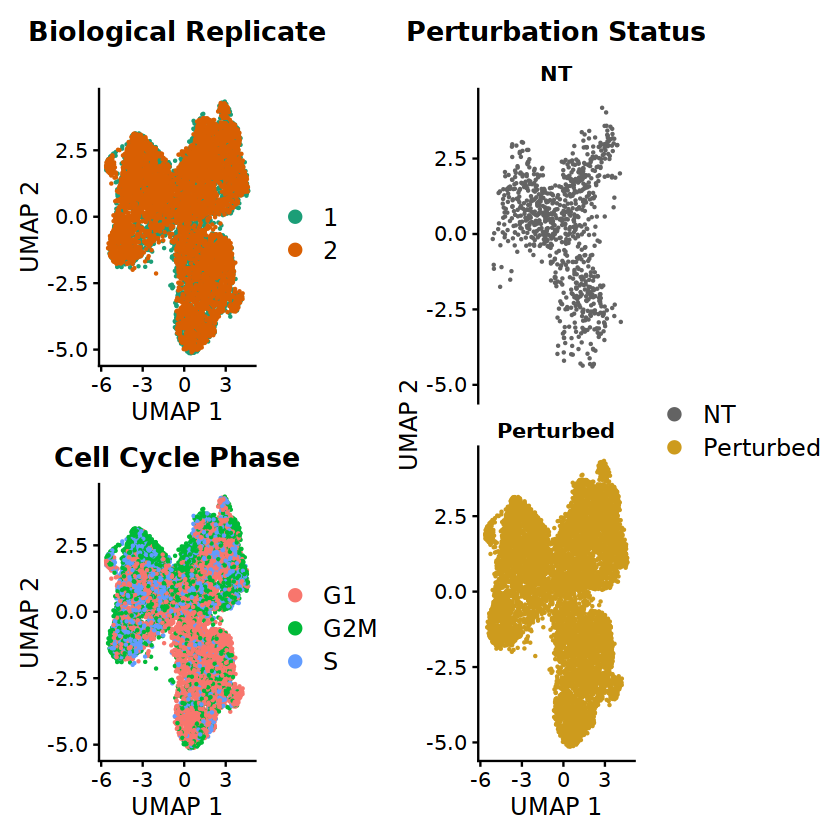

In [30]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
q1 <- DimPlot(
  object = KO15, 
  group.by = 'batch', 
  reduction = 'prtbumap', 
  pt.size = 0.2, cols = "Dark2", label = F, repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

q2 <- DimPlot(
  object = KO15, 
  group.by = 'Phase', 
  reduction = 'prtbumap', 
  pt.size = 0.2, label = F, repel = T) +
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") + 
  custom_theme

q3 <- DimPlot(
  object = KO15,
  group.by = 'crispr',
  reduction = 'prtbumap', 
  split.by = "crispr", 
  ncol = 1, 
  pt.size = 0.2, 
  cols = c("grey39","goldenrod3")) +
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
(q1 / q2 + plot_layout(guides = 'auto') | q3)
# (q1 / q1 + plot_layout(guides = 'auto') | q3)

ggsave(
  paste0("KO15_","_UMAP_postPerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [31]:
# Run mixscape.
KO15 <- RunMixscape(
  object = KO15, 
  assay = "PRTB", 
  slot = "scale.data", 
  labels = "gene", 
  nt.class.name = "NT", 
  min.de.genes = 5,
  iter.num = 10, 
  de.assay = "RNA", 
  verbose = F,
    fine.mode = fine_mode,
  fine.mode.labels = "NT",
  prtb.type = "KO",
    split.by="condition",
    logfc.threshold = 0.1 # default 0.25
)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


number of iterations= 38 
number of iterations= 34 
number of iterations= 34 
number of iterations= 13 
number of iterations= 9 
number of iterations= 18 
number of iterations= 12 
number of iterations= 30 
number of iterations= 25 
number of iterations= 284 
number of iterations= 278 
number of iterations= 281 
number of iterations= 12 
number of iterations= 7 
number of iterations= 24 
number of iterations= 18 
number of iterations= 19 
number of iterations= 19 
number of iterations= 21 
number of iterations= 13 
number of iterations= 43 
number of iterations= 35 
number of iterations= 34 
number of iterations= 8 
number of iterations= 5 
number of iterations= 13 
number of iterations= 9 
number of iterations= 8 
number of iterations= 20 
number of iterations= 14 
number of iterations= 25 
number of iterations= 22 
number of iterations= 22 
number of iterations= 22 
number of iterations= 22 
number of iterations= 22 
number of iterations= 126 
number of iterations= 108 
number of ite

In [32]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_mixscape_Seurat.rds")))

In [33]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_mixscape_Seurat.rds")))
KO15

An object of class Seurat 
33424 features across 9153 samples within 5 assays 
Active assay: PRTB (2289 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [34]:
# save matrix of PRTB counts
PRTB <- GetAssayData(object = KO15, slot = "data")
dim(PRTB)
head(PRTB)
write.csv(PRTB, file=file.path(results_path,paste0('KO15_mixscape_PRTB','.csv')), row.names=TRUE)

[1] 2289 9153

,1_AAACCTGAGAAGAAGC-1,1_AAACCTGAGACTGTAA-1,1_AAACCTGAGGTGTTAA-1,1_AAACCTGCAGGCAGTA-1,1_AAACCTGCAGTCGTGC-1,1_AAACCTGCATTCTCAT-1,1_AAACCTGTCACTCCTG-1,1_AAACGGGAGAGGGCTT-1,1_AAACGGGAGCCAGAAC-1,1_AAACGGGAGGTTACCT-1,⋯,2_TTTGTCAAGCGATTCT-1,2_TTTGTCACAGACAGGT-1,2_TTTGTCACATAAAGGT-1,2_TTTGTCACATAGTAAG-1,2_TTTGTCACATGGTTGT-1,2_TTTGTCAGTAAGGATT-1,2_TTTGTCAGTGACCAAG-1,2_TTTGTCAGTGCGCTTG-1,2_TTTGTCAGTTAAAGAC-1,2_TTTGTCATCGTAGGAG-1
Ifnb1,0.3127866,-0.55711362,0.00000000,3.32868343,0.03690319,1.6607600,0.08260836,-1.7162709,-0.40525491,0.02025591,⋯,0.11477273,-0.2134785,0.02637771,0.1180722,0.07316506,0.00000000,0.32227099,0.00000000,0.2758871,0.9566808
Csf2,0.7517414,0.07288137,0.04798004,0.36212407,0.80480553,0.5214631,1.66526798,-0.5641374,1.56412070,0.00000000,⋯,1.30389221,1.9455900,0.05309384,1.7323115,-0.62729954,0.05677538,1.81144600,0.10638054,1.4202907,1.9455882
Ccl2,-0.1592234,0.23082482,0.16268507,-1.15385176,1.70338355,-0.9492220,1.80423994,-0.6450184,2.91535352,0.28939661,⋯,0.74431879,1.7233453,0.41626397,-0.2286191,0.26806140,0.49231467,0.35925329,0.05955162,-1.1157332,3.1248670
Ccl7,0.1702310,0.00000000,0.00000000,1.02293282,0.00000000,-1.5398545,0.02746218,-1.4890619,0.13089262,0.00000000,⋯,0.08730021,0.0000000,0.00000000,0.6387876,0.78917468,0.00000000,0.02746218,0.00000000,-0.2282083,1.5655653
Ccl5,2.6264365,-0.14468318,2.76944230,1.53971485,-0.65545629,-1.3689524,1.20404485,-0.2718512,-0.71971064,1.96566560,⋯,2.28121877,0.4454084,0.64076441,3.0337853,-0.17939454,1.17736887,2.74020380,0.31957787,1.7122788,1.3024494
Saa3,0.1805926,0.06350269,0.04048972,0.02090377,0.00000000,0.1865719,0.02157767,0.0000000,0.05496874,-0.54504747,⋯,0.09430316,0.1857086,0.10832567,0.2716687,0.11399564,0.07001970,0.00000000,0.05352018,0.3424173,0.2203567


In [35]:
# save mixscape annotation data
write.csv(
    KO15[[c('mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global')]],
    file = file.path(results_path,paste0("KO15_mixscape_annotations.csv")),
    row.names=TRUE
    )

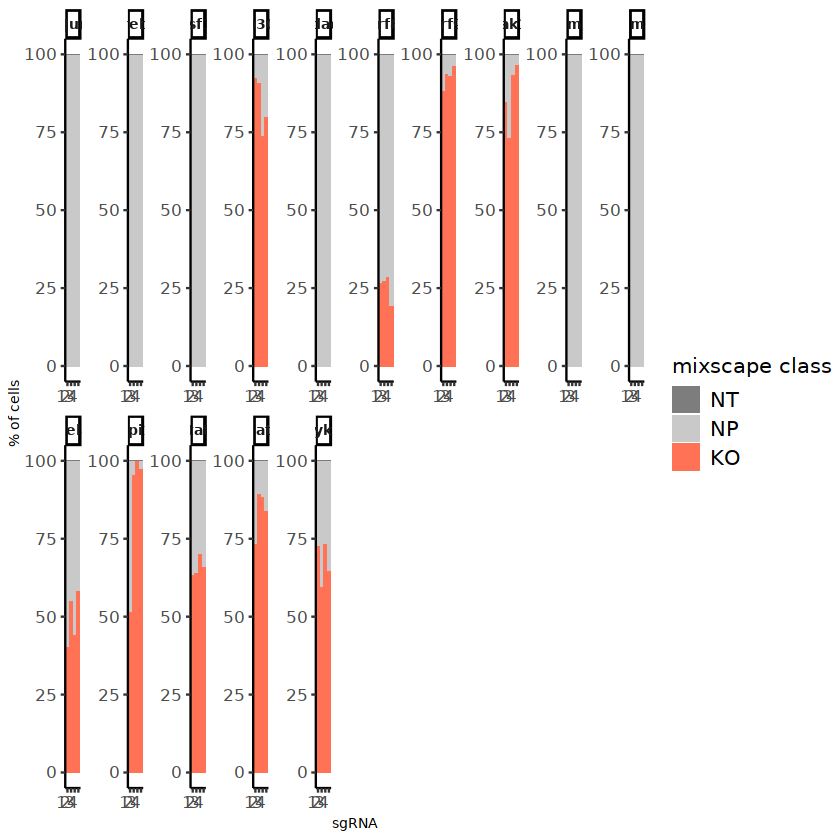

In [36]:
# Calculate percentage of KO cells for all target gene classes.
df <- prop.table(table(KO15$mixscape_class.global, KO15$NT),2)

df2 <- reshape2::melt(df)
df2$Var2 <- as.character(df2$Var2)
test <- df2[which(df2$Var1 == "KO"),]
test <- test[order(test$value, decreasing = T),]
new.levels <- test$Var2
df2$Var2 <- factor(df2$Var2, levels = new.levels )
df2$Var1 <- factor(df2$Var1, levels = c("NT", "NP", "KO"))
df2$gene <- sapply(as.character(df2$Var2), function(x) gsub("g.$", "", x))
df2$guide_number <- sapply(as.character(df2$Var2), 
                           function(x) tail(strsplit(x, split = "g")[[1]],1))
df3 <- df2[-c(which(df2$gene == "NT")),]

p1 <- ggplot(df3, aes(x = guide_number, y = value*100, fill= Var1)) +
  geom_bar(stat= "identity") +
  theme_classic()+
  scale_fill_manual(values = c("grey49", "grey79","coral1")) + 
  ylab("% of cells") +
  xlab("sgRNA")

p1 + theme(axis.text.x = element_text(size = 10, hjust = 1), 
           axis.text.y = element_text(size = 10), 
           axis.title = element_text(size = 8), 
           strip.text = element_text(size=8, face = "bold")) + 
  facet_wrap(vars(gene),ncol = 10, scales = "free") +
  labs(fill = "mixscape class") +theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12))

ggsave(
  paste0("KO15_","_PercentageKO_all",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
    height=20,
    width=20
)

### Unsupervised analysis of PRTB perturbed cells

In [37]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO15) <- "mixscape_class.global"
sub_test <- subset(KO15, idents = c("KO", "NT"))
sub_test

An object of class Seurat 
33424 features across 4978 samples within 5 assays 
Active assay: PRTB (2289 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [38]:
# make new labels: condition+KO
sub_test[["gene_new"]] <- paste(sub_test$condition,sub_test$gene,sep="+")
# sub_all$gene_new[grep("+NT$",sub_all$gene_new)] <- 'NT'
unique(sub_test$gene_new)

[1] "LO28_2h+Stat1"   "LO28_6h+NT"      "LO28_2h+Irf9"    "LO28_6h+Stat1"  
 [5] "LO28_2h+NT"      "LO28_6h+Tyk2"    "untreated+Stat1" "LO28_2h+Stat2"  
 [9] "untreated+NT"    "LO28_6h+Irf9"    "LO28_6h+Ep300"   "untreated+Irf9" 
[13] "untreated+Stat2" "LO28_6h+Irf8"    "LO28_2h+Rela"    "untreated+Spi1" 
[17] "LO28_6h+Spi1"    "LO28_2h+Tyk2"    "untreated+Ep300" "LO28_6h+Rela"   
[21] "LO28_2h+Spi1"    "LO28_6h+Jak1"    "LO28_2h+Ep300"   "untreated+Jak1" 
[25] "untreated+Tyk2"  "LO28_6h+Stat2"   "LO28_2h+Jak1"

In [39]:
DefaultAssay(object = sub_test)

[1] "PRTB"

In [40]:
DefaultAssay(object = sub_test) <- 'RNA'
sub_test <- NormalizeData(object = sub_test) %>% FindVariableFeatures() %>% ScaleData()
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = sub_test) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = sub_test) <- VariableFeatures(object = sub_test[["RNA"]])
sub_test <- ScaleData(object = sub_test, do.scale = F, do.center = T)

Centering and scaling data matrix

Warning message:
“Not all features provided are in this Assay object, removing the following feature(s): 1810034E14Rik, Tesc, Tnfaip6, Gng8, Rab11fip4, 4833413E03Rik, Vangl2, Hist1h3a, Clec10a, 4930500M09Rik, Adam33, Ovgp1, Ceacam19, Retn, Ctxn1, Fam196b, Gm48228, Extl1, Arrdc2, Dpf3, Ptch1, 6030468B19Rik, Gm32552, Gpld1, Gm32051, Gipr, Gm35037, Gm5149, Ifi206, Mfap3l, Rbl1, Srpk3, Tmsb15b1, Gm42567, Tal2, Abcb1a, Gm15932, Mipepos, Trpm3, Asb4, Gm20442, Fads3, Ppp2r3a, Abca5, Gm19412, D430036J16Rik, Cdk5rap2, St3gal5, Haus6, Kif21b, Lrr1, Tcp11, Dlg3, Gm15860, Card14, Dock4, Mtss1, 9130230L23Rik, Sema4c, Rab26os, Rab31, Slc9a4, Zfp771, Hsd17b7, Rnd1, Gm20186, Agl, Bcl2a1c, Nasp, Gm6329, Aox2, Rai14, 1700024B05Rik, AC117662.4, Slc16a14, Itih5, Rapsn, Zfp600, Wasf1, Mef2b, Tnfsf13os, Gm30411, Cd200r4, Rnf151, Rnf135, Usp2, Lncpint, Dnaaf2, Clstn3, Cnksr1, E2f2, Cdkn2c, Hebp1, Znhit3, Suv39h1, Frk, Tst, Rraga, Erfe, Jag1, C130050O18Rik, Gm19710, Spink2, 

In [41]:
# Run PCA to reduce the dimensionality of the data.
sub_test <- RunPCA(object = sub_test, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
sub_test <- RunUMAP(
  object = sub_test, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Irf7, Ifi27l2a, Isg15, Bst2, Usp18, Ly6e, Isg20, Ifi44, Phf11d, Ifitm3 
	   Slfn4, Rsad2, Rtp4, Xaf1, Ifit1, Rnf213, Ifit2, Ifi202b, Cmpk2, Oasl1 
	   Oasl2, Lgals9, Lgals3bp, Ifit3, Apol9a, Irgm1, Ifi207, Cxcl10, Ddx58, Zbp1 
Negative:  H2-Aa, H2-Eb1, Cd74, Vim, Herpud1, Spp1, mt-Cytb, Fth1, Car2, Ifi27 
	   Cd52, Tnip3, Mt1, Cyth4, Phlda1, Ank, Ccnd1, Glipr1, Ets2, Cfp 
	   H2afz, Cd72, Lgals3, Hist1h1e, Tmsb10, P4hb, Ccl9, H2-Ab1, Csf1r, Odc1 
prtbpca_ 2 
Positive:  Cxcl2, Il1b, Il1a, Tnf, Ccl4, Ccl3, Acod1, Ptgs2, Atf3, Phlda1 
	   Ccl9, Ccl2, Csf2, Rgs1, Cxcl10, Zfp36, Nfkbiz, Ier3, Ccl5, Ppp1r15a 
	   Rsad2, Pdgfb, H2-Aa, H2-Eb1, Marcksl1, Tnip3, Cd83, Dusp2, Junb, Mir155hg 
Negative:  Ifi27l2a, Rae

Saving 6.67 x 6.67 in image



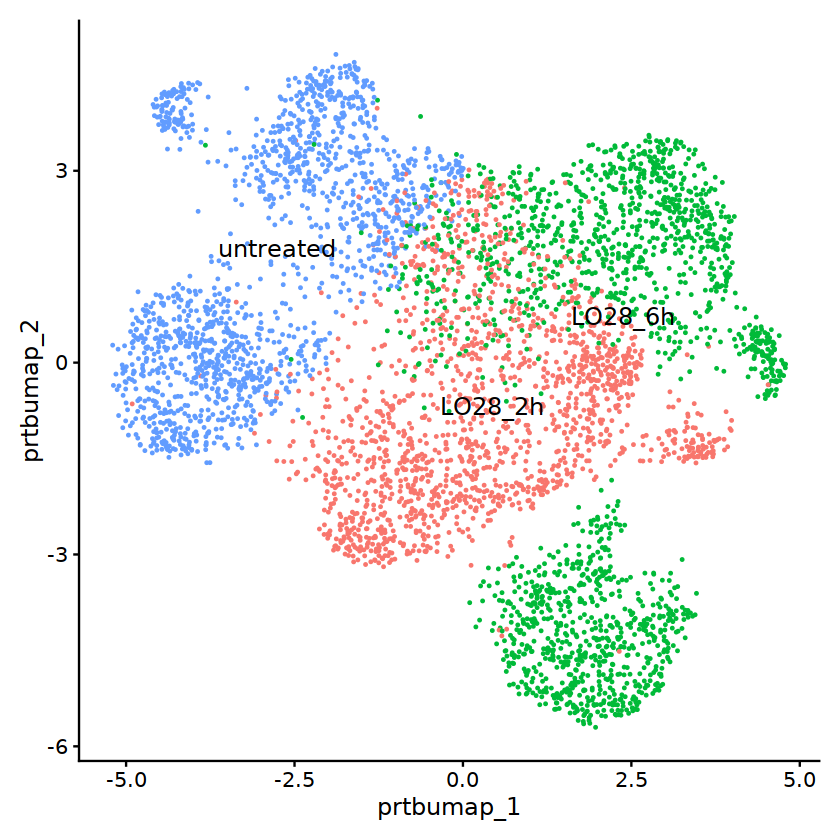

In [42]:
Idents(sub_test) <- "condition"

DimPlot(object = sub_test,
             reduction = "prtbumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO15_",'UMAP_PRTB_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



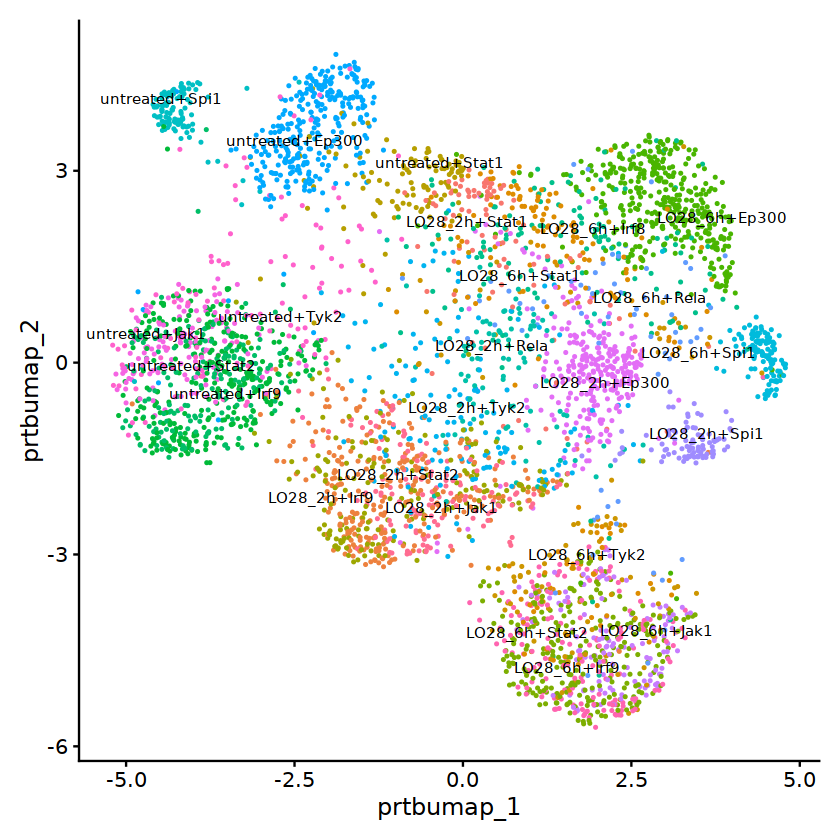

In [43]:
Idents(sub_test) <- "gene_new"

DimPlot(object = sub_test,
        cells=colnames(sub_test)[sub_test$mixscape_class!='NT'],
             reduction = "prtbumap", 
             repel = T, 
             label.size = 3, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO15_",'UMAP_PRTB_condition_KO', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

### LDA of PRTB perturbed cells

In [44]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO15) <- "mixscape_class.global"
sub <- subset(KO15, idents = c("KO", "NT"))

In [45]:
# Run LDA.
sub <- MixscapeLDA(
  object = sub, 
  assay = "RNA", 
  pc.assay = "PRTB", 
  labels = "gene", 
  nt.label = "NT", 
  npcs = 10, 
  logfc.threshold = 0.25, 
  verbose = F)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [46]:
# Use LDA results to run UMAP and visualize cells on 2-D. 
# Here, we note that the number of the dimensions to be used is equal to the number of 
# labels minus one (to account for NT cells).
sub <- RunUMAP(
  object = sub,
  dims = 1:(length(unique(sub$mixscape_class))-1),
  reduction = 'lda',
  reduction.key = 'ldaumap',
  reduction.name = 'ldaumap')

17:24:15 UMAP embedding parameters a = 0.9922 b = 1.112

17:24:15 Read 4978 rows and found 9 numeric columns

17:24:15 Using Annoy for neighbor search, n_neighbors = 30

17:24:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:24:16 Writing NN index file to temp file /home/sreichl/tmp//RtmpufGzzp/file66bd77a0a80f

17:24:16 Searching Annoy index using 1 thread, search_k = 3000

17:24:17 Annoy recall = 100%

17:24:18 Commencing smooth kNN distance calibration using 1 thread

17:24:19 Initializing from normalized Laplacian + noise

17:24:19 Commencing optimization for 500 epochs, with 200620 positive edges

17:24:34 Optimization finished

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ldaumap to ldaumap_

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



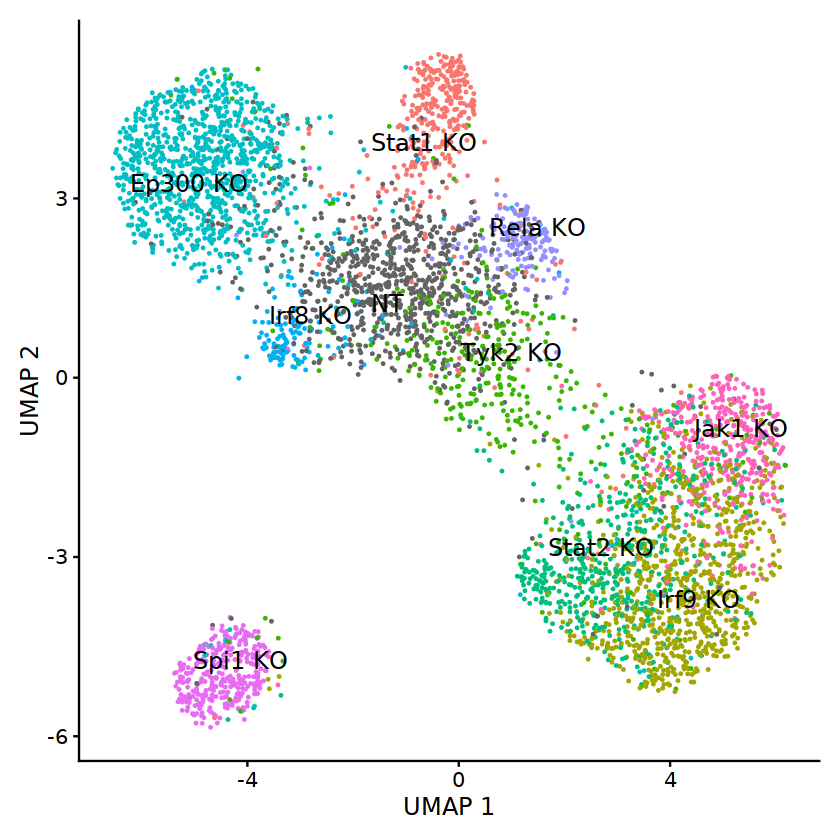

In [47]:
# Visualize UMAP clustering results.
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             reduction = "ldaumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO15_",'UMAP_LDA_KO_', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



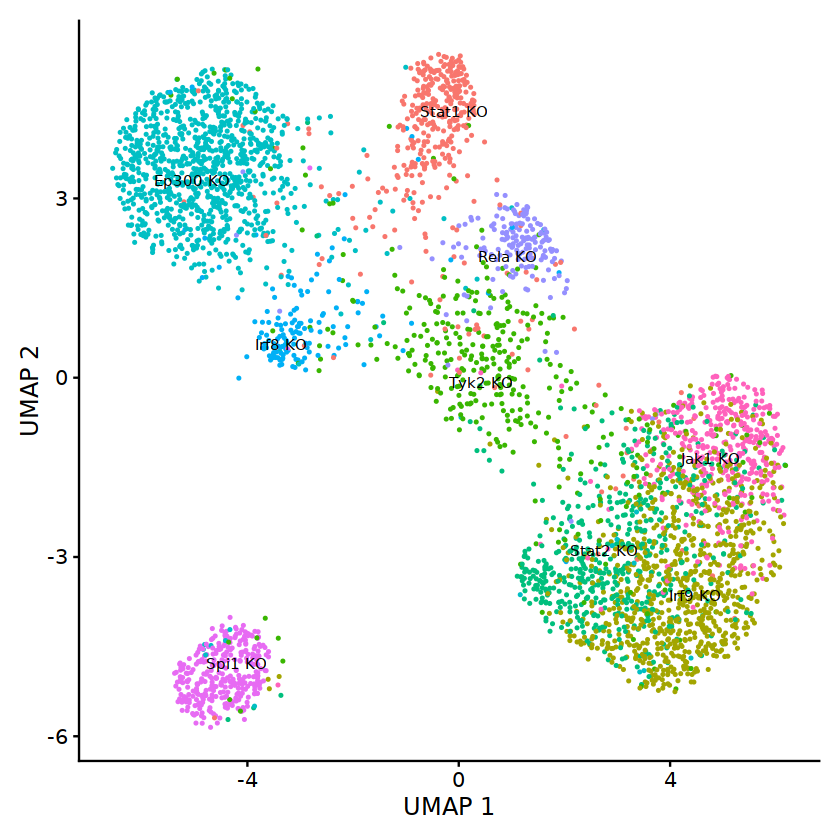

In [48]:
# Visualize UMAP clustering results without NT cells
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             cells=colnames(sub)[sub$mixscape_class!='NT'],
             reduction = "ldaumap", 
             repel = T, 
             label.size = 3, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO15_",'UMAP_LDA_KO_','pure', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



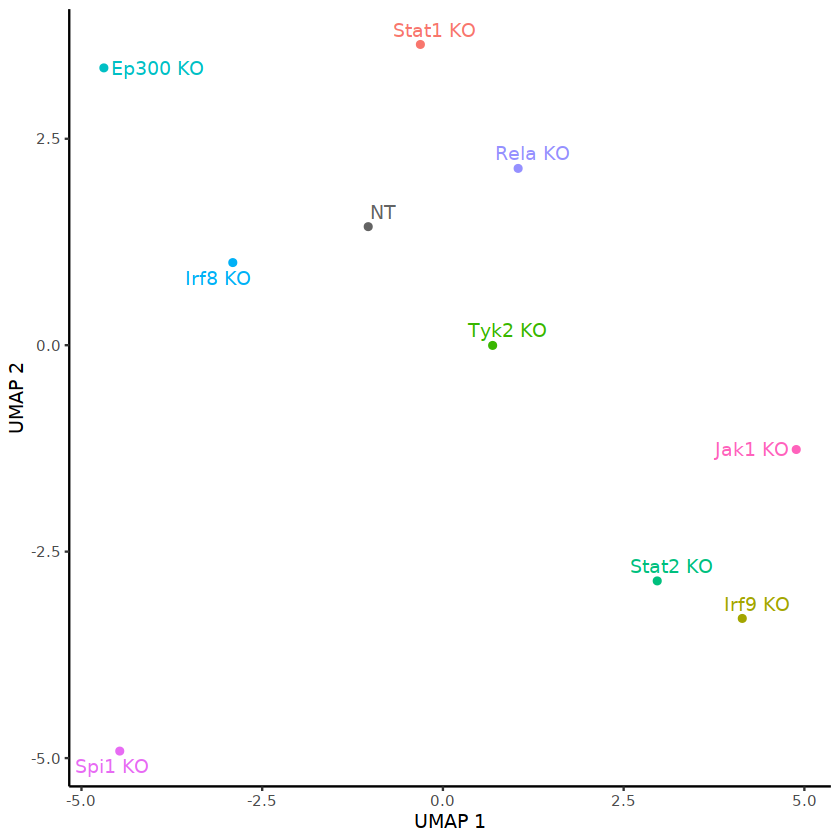

In [49]:
# plot only the centroids
ldaumap_data <- Embeddings(object = sub, reduction = "ldaumap")
ldaumap_data <- data.frame(ldaumap_data)
ldaumap_data$mixscape_class <- sub$mixscape_class[rownames(ldaumap_data)]

ldaumap_means <- aggregate(ldaumap_data[, c('ldaumap_1','ldaumap_2')], list(ldaumap_data$mixscape_class), mean)

p <- ggplot(ldaumap_means, aes(ldaumap_1, ldaumap_2, colour = Group.1)) + 
    geom_point()  + 
    geom_text_repel(aes(label=Group.1))

p1 <-  p+ 
    scale_color_manual(values=col, drop=FALSE) +
    ylab("UMAP 2") +
    xlab("UMAP 1") +
    theme_classic()+ 
    NoLegend()

p1

ggsave(
  paste0("KO15_",'UMAP_LDA_KO_','centroids', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [50]:
# save Seurat object
saveRDS(sub, file = file.path(results_path,paste0("KO15_mixscape_subset_Seurat.rds")))

In [51]:
# loading Seurat object
sub <-readRDS(file = file.path(results_path,paste0("KO15_mixscape_subset_Seurat.rds")))
sub

An object of class Seurat 
33424 features across 4978 samples within 5 assays 
Active assay: PRTB (2289 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 6 dimensional reductions calculated: pca, umap, prtbpca, prtbumap, lda, ldaumap